In [1]:
# uncomment if you haven't installed the package
# !pip install -e "git+https://github.com/daffarobani/smt-explainability.git"#egg=smt-ex
# !pip install sobolsampling

In [2]:
import numpy as np
import math

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from smt.surrogate_models import KRG
from smt.problems import WingWeight
from smt.sampling_methods import LHS

from smt_ex.sobol import SobolIndices
from smt_ex.sobol import SobolIndicesDisplay

In [3]:
ndoe = 100
fun = WingWeight()
sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1)
X = sampling(ndoe)
y = fun(X)

n_train = int(0.8 * ndoe)

X_tr, y_tr = X[:n_train, :], y[:n_train]
X_te, y_te = X[n_train:, :], y[n_train:]

## config
feature_names = [
    r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$',
    r'$q$', r'$\lambda$', r'$t_{c}$', r'$N_{z}$',
    r'$W_{dg}$', r'$W_{p}$',
]

class GroundTruthModel:
    def predict_values(self, X):
        return fun(X)

# kriging model
sm = KRG(
    theta0=[1e-2]*X_tr.shape[1],
    print_prediction = False
    )
sm.set_training_values(
    X_tr,
    y_tr
    )

sm.train()

print("Surrogate model")
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

# ground truth model
gtm = GroundTruthModel()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  8.9643838
Surrogate model
RMSE: 0.6717
rRMSE: 0.0025


/Users/muhammaddaffarobani/miniconda3/envs/smt_ex_39/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [4]:
x_bounds = fun.xlimits
nvar = X.shape[1]
model = gtm
n_mc = 1e5
first_order = True
total_order = True
second_order = True

gt_sobol_display = SobolIndicesDisplay.from_surrogate_model(
    nvar,
    model,
    x_bounds=x_bounds,
    n_mc=n_mc,
    first_order=first_order,
    total_order=total_order,
    second_order=second_order,
    feature_names=feature_names,
)

In [5]:
x_bounds = fun.xlimits
nvar = X.shape[1]
model = sm
n_mc = 1e5
first_order = True
total_order = True
second_order = True

sobol_display = SobolIndicesDisplay.from_surrogate_model(
    nvar,
    model,
    x_bounds=x_bounds,
    n_mc=n_mc,
    first_order=first_order,
    total_order=total_order,
    second_order=second_order,
    feature_names=feature_names,
)

In [6]:
gt_sobol_display.sobol_indices

{'first': array([ 1.24343900e-01, -1.30746692e-04,  2.20185816e-01,  3.55527973e-04,
        -4.51695893e-05,  1.67308774e-03,  1.40729721e-01,  4.11559435e-01,
         8.48490279e-02,  3.21931862e-03]),
 'total': array([ 1.27687901e-01, -3.54422837e-04,  2.25630961e-01,  1.46038352e-04,
        -2.65978668e-04,  1.50165129e-03,  1.44995710e-01,  4.19502849e-01,
         8.74530745e-02,  2.99491946e-03]),
 'second': {'x0-x1': 0.00013390102765446324,
  'x0-x2': 0.0010044558347755417,
  'x0-x3': 0.00013442091751711855,
  'x0-x4': 0.00013375665669141138,
  'x0-x5': 0.00013333838278224317,
  'x0-x6': 0.0006828573902208368,
  'x0-x7': 0.0017773720450677266,
  'x0-x8': 0.00048814803893142134,
  'x0-x9': 0.0001564121255827615,
  'x1-x2': 0.00013387713091475573,
  'x1-x3': 0.0001339638380443388,
  'x1-x4': 0.00013396155654315817,
  'x1-x5': 0.0001339556674630094,
  'x1-x6': 0.00013394089495910588,
  'x1-x7': 0.00013352351968531906,
  'x1-x8': 0.00013388338291264734,
  'x1-x9': 0.0001339666105

In [7]:
sobol_display.sobol_indices

{'first': array([ 1.24765395e-01, -1.45179187e-04,  2.20740921e-01,  4.59467020e-04,
        -5.23506423e-05,  1.62790644e-03,  1.41882459e-01,  4.11054202e-01,
         8.33396236e-02,  3.07085111e-03]),
 'total': array([ 1.28211933e-01, -2.00207170e-04,  2.26670965e-01,  4.60603637e-04,
        -1.07256859e-04,  1.60855638e-03,  1.46237476e-01,  4.18677809e-01,
         8.58455402e-02,  3.00536651e-03]),
 'second': {'x0-x1': 0.0001465202414227062,
  'x0-x2': 0.0012004284129539244,
  'x0-x3': 0.00015096156792452416,
  'x0-x4': 0.00014644891429022874,
  'x0-x5': 0.00014837367968477747,
  'x0-x6': 0.000619139429770349,
  'x0-x7': 0.0017472081946390272,
  'x0-x8': 0.0004574804324261883,
  'x0-x9': 0.00014943968617774344,
  'x1-x2': 0.0001465346516122401,
  'x1-x3': 0.00014648689253898178,
  'x1-x4': 0.00014642790547153944,
  'x1-x5': 0.00014642825747930121,
  'x1-x6': 0.00014641508875604115,
  'x1-x7': 0.00014639664886628712,
  'x1-x8': 0.0001463087727551493,
  'x1-x9': 0.000146423872053

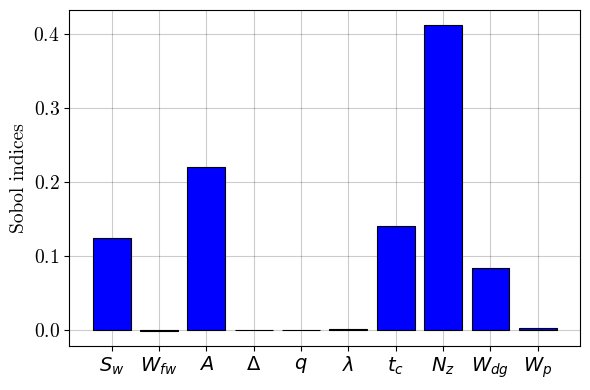

In [8]:
gt_sobol_display.plot('first')

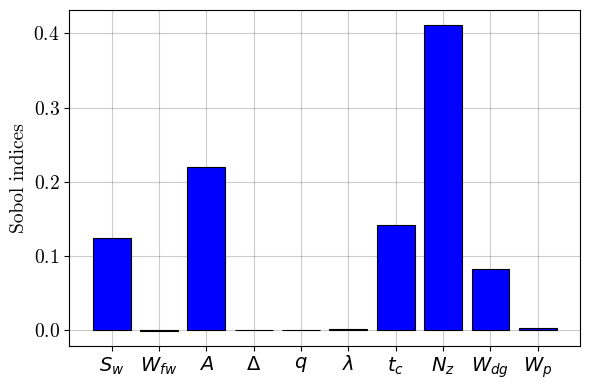

In [9]:
sobol_display.plot('first')

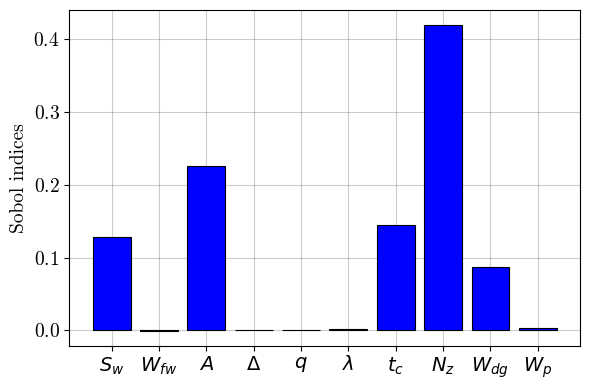

In [10]:
gt_sobol_display.plot('total')

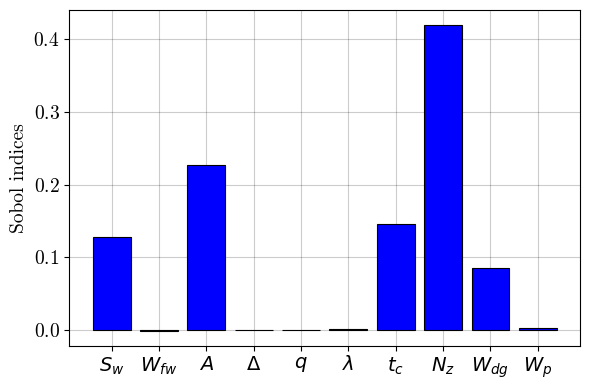

In [11]:
sobol_display.plot('total')

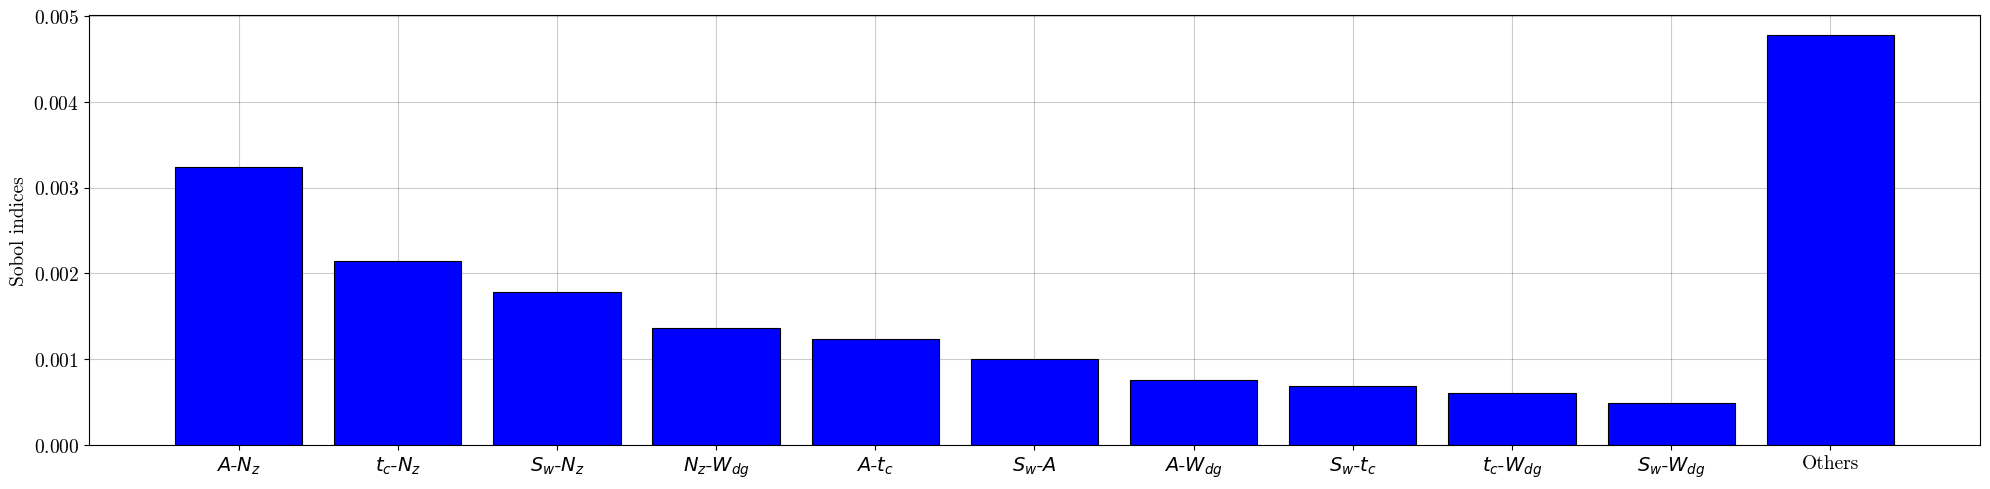

In [12]:
gt_sobol_display.plot('second', sort=True, max_num_display=10, figsize=[20, 5])

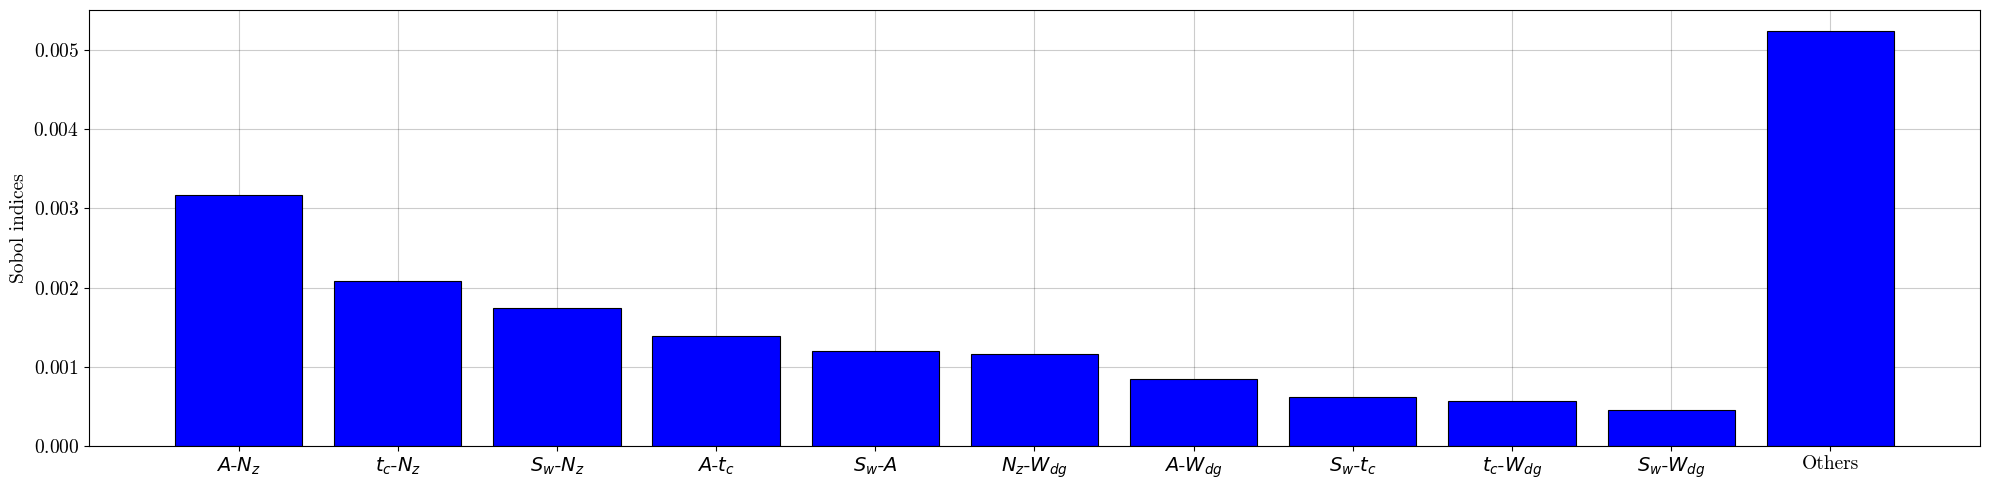

In [13]:
sobol_display.plot('second', sort=True, max_num_display=10, figsize=[20, 5])